In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, optimization_visualization_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
importlib.reload(optimization_visualization_helper)

from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint, get_max_distance_to_target_surface, get_average_distance_to_target_joint, get_fixed_boundary_joint)

from optimization_visualization_helper import (compute_visualization_data_from_raw_data, get_objective_components_stage1, get_objective_components_stage2, get_objective_components_stage3, set_figure_label_and_limit, Visualization_Setting, plot_objective, plot_objective_stack, plot_ribbon_component_analysis, insert_nan)
import vis.fields
import matplotlib.cm as cm
import time

import matplotlib.pyplot as plt
import json

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(24)
parallelism.set_hessian_assembly_num_threads(8)
parallelism.set_gradient_assembly_num_threads(8)

In [3]:
# rod_length = curved_linkage.totalRestLength() / curved_linkage.numSegments()
rod_length = 0.079785061039255
width = rod_length / 25 * 5
thickness = width / 5 * 0.5
print(width, thickness)
scale = 1
io = InputOrganizer('lilium_{}'.format(scale), thickness, width, weaving_dir)

0.015957012207851003 0.0015957012207851004


In [16]:
import py_newton_optimizer
# Optimization parameters.
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 0.1
sw = 10
drw = 0.01
dsw = 0.1

In [17]:
import pickle
import gzip

In [18]:
import benchmark

In [19]:
benchmark.reset()

In [20]:
# curved_linkage = pickle.load(gzip.open('{}_stage_2_20201228.pkl.gz'.format(io.MODEL_NAME), 'r'))
# curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
# curved_save_tgt_joint_pos = curved_linkage.jointPositions();
# set_surface_view_options(curved_linkage_view, linkage_color='lightgreen')
# curved_linkage_view.show()

In [21]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [22]:
benchmark.report()

Construct Factorizer	0.00123811	1
    Compress Matrix	0.00111413	1
RodLinkage<Real>.setDoFs	0.00376225	3
Update closest points	0.860108	1
fixVariables	0.000156879	1
CHOLMOD Backsub	0.000148058	1
CHOLMOD Numeric Factorize	0.00216007	1
CHOLMOD Symbolic Factorize	0.015656	1
Full time	5.79595


In [23]:
def callback(prob, i):
    pass

In [24]:
E0 = curved_linkage.designParameterSolve_energy()
l0 = curved_linkage.totalRestLength()

In [25]:
benchmark.reset()

In [26]:
iterateData = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view)

In [27]:
benchmark.report()

Compress Matrix	0.04969	3
Newton iterations	77.0765	1
    Newton iterate	77.0742	130
        Backtracking	1.60099	130
            RodLinkage<Real>.setDoFs	0.686544	479
        Compute descent direction	70.5296	130
            newton_step	70.4915	130
                Newton solve	49.7695	298
                    CHOLMOD Numeric Factorize	35.5032	297
                    RodLinkage<Real>.massMatrix	7.33645	103
                    Solve	3.32128	298
                        CHOLMOD Backsub	2.4162	298
                        CHOLMOD Numeric Factorize	0.114434	1
                        CHOLMOD Symbolic Factorize	0.538419	1
                RodLinkage<Real>.massMatrix	0.0781541	1
                hessEval	19.6015	130
                    hessianPerSegmentRestlen	18.0758	130
                        RodLinkage<Real>.hessian	12.5495	130
                largestMagnitudeEigenvalue	0.189507	2
        Preamble	4.6587	130
            Callback	2.95292	130
            RodLinkage<Real>.gradient	1.04143	130
   

In [45]:
curved_linkage.attraction_weight = 1e-5

In [39]:
fixed_boundary_joints = get_fixed_boundary_joint(curved_linkage)

In [46]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [47]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = fixed_boundary_joints)

0	4.28981e-06	0.0122478	0.0122478	1	1
1	3.14441e-06	4.24657e-05	4.24657e-05	1	0
2	3.14352e-06	5.79219e-06	5.79219e-06	1	0
3	3.14352e-06	7.19678e-10	7.19678e-10	1	0


In [30]:
contact_data = np.load('../../../optimization_diagram_results/lilium_1/lilium_1_stage_3.npy', allow_pickle = True)

In [43]:
stage_2_data = np.load('../../../optimization_diagram_results/lilium_1/lilium_1_stage_2.npy', allow_pickle = True)

In [44]:
curved_linkage.setExtendedDoFsPSRL(stage_2_data[-1]['extendedDoFsPSRL'])

In [34]:
# import pickle
# import gzip
# pickle.dump(curved_linkage, gzip.open('{}_stage_2_20201228.pkl.gz'.format(io.MODEL_NAME), 'w'))

In [35]:
# optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, fixed_boundary_joint = fixed_boundary_joints)
# optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -5, 3)

In [20]:
# curved_optimizer_energy = curved_linkage.energy()
# validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
# validation_curved_linkage.attraction_weight = 1e-7
# with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = fixed_boundary_joints)
# validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
# validation_curved_energy = validation_curved_linkage.energy()
# print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

In [21]:
# deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(validation_curved_linkage)

In [18]:
# validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
# set_surface_view_options(validation_curved_view)
# validation_curved_view.show()

In [19]:
# set_joint_vector_field(validation_curved_linkage, validation_curved_view, deviation_vector)

In [20]:
# save_path = os.getcwd()
# write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
# os.chdir(save_path)

## Extra Utility Functions for Fabrication

In [ ]:
mesh_scale = 313.3418671911495

In [ ]:
ribbons = order_segments_by_ribbons(curved_linkage)
new_rod, fixedVars = construct_elastic_rod_loop_from_rod_segments(curved_linkage, ribbons[0])

In [ ]:
new_rod.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, io.RIBBON_CS, stiffAxis=elastic_rods.StiffAxis.D1))
single_rod_view = linkage_vis.LinkageViewer(new_rod, width=1024, height=640)

In [ ]:
single_rod_view.show()

In [ ]:
export_linkage_geometry_to_obj(new_rod, 'results/lilium_1/boundary_rod.obj', scale = mesh_scale)

In [ ]:
all_centerline_pos, all_rest_kappas, all_material_frame = concatenate_rod_properties_from_rod_segments(curved_linkage, ribbons[0])

In [ ]:
len(all_material_frame)

In [ ]:
with open('results/lilium_1/boundary_rod_curve.obj', 'w') as f:
    for point in all_centerline_pos:
        point *= mesh_scale
        f.write('v {} {} {}\n'.format(point[0], point[1],point[2]))
    for i in range(len(all_centerline_pos)-1):
        f.write('l {} {}\n'.format(i+1, i+2))
    f.write('l {} {}\n'.format(len(all_centerline_pos), 1))

In [ ]:
point_list = []
edge_list = []
face_list = []
with open('../../../../normalized_objs/surface_models/lilium_1.obj', 'r') as surface, open('results/lilium_1/lilium_surface_scale_{}.obj'.format(str(int(mesh_scale))), 'w') as output_surface:
    surface_content = surface.readlines()
    for line in surface_content:
        if 'v ' in line:
            point = np.array([float(x) for x in line.split(' ')[1:]])
            point *= mesh_scale
            output_surface.write('v {} {} {}\n'.format(point[0], point[1], point[2]))
        else:
            output_surface.write(line)

In [ ]:
curved_linkage.jointPositions()[49 * 3:50 * 3] * mesh_scale

## Contact Optimization

In [7]:
# with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
# curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
# curved_save_tgt_joint_pos = curved_linkage.jointPositions();
# curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
# set_surface_view_options(curved_linkage_view)
# curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [8]:
# curved_linkage.setExtendedDoFsPSRL(np.load('results/lilium_1/lilium_1_dof.npy'))

In [9]:
# fixed_boundary_joints = get_fixed_boundary_joint(curved_linkage)

In [10]:
# curved_linkage.attraction_weight = 1e-5

In [11]:
# def eqm_callback(prob, i):
#     curved_linkage_view.update()

In [46]:
# elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = fixed_boundary_joints)

In [18]:
import benchmark

In [19]:
benchmark.reset()

In [20]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw, fixed_boundary_joint = fixed_boundary_joints, inner_gradTol = 1e-6)

In [21]:
benchmark.report()

Newton iterations	0.00694394	1
    Newton iterate	0.00570917	1
        Preamble	0.00570679	1
            Callback	0.000372887	1
            SurfaceAttractedLinkage<Real>.gradient	0.00393701	1
                RodLinkage<Real>.gradient	0.00359106	1
RodLinkage<Real>.applyHessianPSRL	0.00803494	2
    RodLinkage<Real>.applyHessian	0.00674987	2
RodLinkage<Real>.gradient	0.00694394	4
RodLinkage<Real>.setDoFs	0.000843048	1
SurfaceAttractedLinkage<Real>.gradient	0.007514	2
    RodLinkage<Real>.gradient	0.00692415	2
Update closest points	3.07748	5
newton_step	0.306816	1
    Newton solve	0.261873	1
        Solve	0.260602	1
            CHOLMOD Backsub	0.00362182	1
            CHOLMOD Numeric Factorize	0.062418	1
            CHOLMOD Symbolic Factorize	0.193914	1
    hessEval	0.044101	1
        SurfaceAttractedLinkage<Real>.hessian	0.0349908	1
            RodLinkage<Real>.hessian	0.0341339	1
Full time	3.75507


In [22]:
benchmark.reset()

In [23]:
optimizer.setLinkageAttractionWeight(1e-5)

In [24]:
benchmark.report()

Newton iterations	0.00588489	1
    Newton iterate	0.00449705	1
        Preamble	0.00449395	1
            Callback	0.000366926	1
            SurfaceAttractedLinkage<Real>.gradient	0.00265813	1
                RodLinkage<Real>.gradient	0.00233698	1
RodLinkage<Real>.applyHessianPSRL	0.00396395	1
    RodLinkage<Real>.applyHessian	0.00337696	1
RodLinkage<Real>.gradient	0.00329208	2
RodLinkage<Real>.setDoFs	0.00118899	1
SurfaceAttractedLinkage<Real>.gradient	0.005054	1
    RodLinkage<Real>.gradient	0.00412011	1
Update closest points	1.58522	2
newton_step	0.0986271	1
    Newton solve	0.0602691	1
        CHOLMOD Numeric Factorize	0.0541921	1
        Solve	0.00407887	1
            CHOLMOD Backsub	0.00342512	1
    hessEval	0.0375531	1
        SurfaceAttractedLinkage<Real>.hessian	0.032568	1
            RodLinkage<Real>.hessian	0.0317919	1
Full time	1.74334


../../../../elastic_rods/python/structural_analysis.py:213: RuntimeWarning: invalid value encountered in true_divide
  coefficientOfFriction = cfm[:, 1] / (-separationForce)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


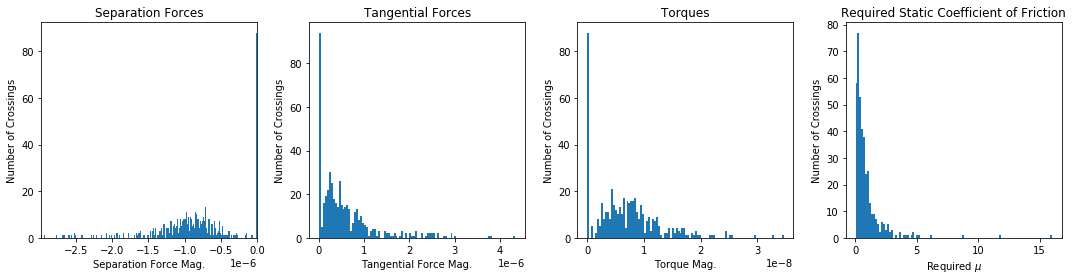

In [42]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [26]:
from structural_analysis import weavingCrossingForceMagnitudes
cfm = weavingCrossingForceMagnitudes(curved_linkage, True)

In [27]:
np.percentile(cfm[:, 0], 50)

-8.229312001189132e-07

In [28]:
benchmark.reset()

In [ ]:
with so(): optimizer, opt_iterateData, weight_change_iters = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, None, -1, -5, 1, True)

In [ ]:
benchmark.report()

In [ ]:
with so(): optimizer, contact_iterateData = contact_optimization(optimizer, curved_linkage, None, minRestLen=-1, contact_weight = 5e6, normalActivationThreshold = np.percentile(cfm[:, 0], 50), normalWeight = 10, tangentialWeight = 1, torqueWeight = 0, maxIter=2000)

../../../../elastic_rods/python/structural_analysis.py:213: RuntimeWarning: invalid value encountered in true_divide
  coefficientOfFriction = cfm[:, 1] / (-separationForce)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yren/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


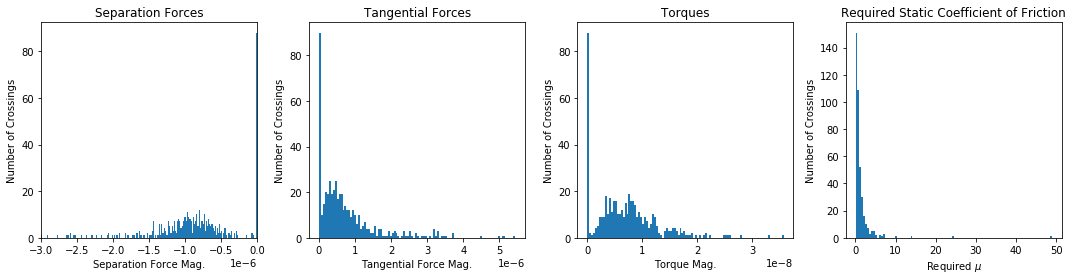

In [48]:
structure_view_2 = get_structure_analysis_view(curved_linkage)
structure_view_2.show()